# Genetic Programming (Part 1)

This chapter introduces some very basic concepts about Genetic Programming. As usual, we will require a couple of imports:

In [1]:
import random
import sys
import re
import matplotlib.pyplot as plt
from statistics import mean

# For presenting as slides
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams.update({'font.size': 22})
#plt.rcParams['lines.linewidth'] = 3

## Classic Genetic Programming

The main difference between regular Genetic Algorithms and Genetic Programming lies in the representation: GAs tend to operate on the genotype, while GPs operate on the phenotype (programs); for this, the programs are traditionally represented as trees. Furthermore, GPs have a more open-ended nature in that the number of elements used in a solution as well as their interconnections must be open to evolution.

In a tree representation, programs are typically generated using two sets: A set of terminals (items of arity 0) and functions (items of arity > 0). The input to a function must be the result of any other function that can be defined, which leads to the important property of _type closure_: Each function must be able to handle all values it might ever receive as input, all terminals must be allowable inputs for all functions, and the output from any function must be a permitted input to any other function. 

The first step to evolving a suitable program for a given problem is thus to define the sets of functions and terminals:

In [2]:
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def div(x, y): return 1 if not y else x/y

In [3]:
FUNCTIONS = [add, sub, mul, div]
TERMINALS = ['A', 'B', 'C', 'D']

### Initialisation

Our usual approach to define the presentation is by introducing code that creates random instances. Let's do the same here, except that this time we need to use a tree representation. For this, we define a suitable datastructure:

In [4]:
class Node:
    
    def __init__(self, data=None, left=None, right=None):
        self.data = data
        self.left = left
        self.right = right

    def __str__(self):
        if self.data in FUNCTIONS:
            return self.data.__name__
        else:
            return str(self.data)
        
    def to_dot(self, dot):
        dot.node(str(id(self)), str(self))
        
        if self.left:
            left_dot = self.left.to_dot(dot)
            dot.edge(str(id(self)), str(id(self.left)))

        if self.right:
            right_dot = self.right.to_dot(dot)
            dot.edge(str(id(self)), str(id(self.right)))

        return dot      

The `to_dot` function is a helper function we will use in order to represent trees visually using GraphViz (which will need to be installed on your machine if you want to run this Jupyter notebook).

In [5]:
from graphviz import Digraph

In [6]:
def print_tree(tree):
    dot = Digraph()
    tree.to_dot(dot)
    return dot

#### Full Initialisation

A basic approach to creating random trees is to grow full trees. We decide on a maximum depth for our tree, and then add non-terminal nodes until the depth limit is reached. Once we have reached it, we only add terminals as leaves. 

In [7]:
MAX_DEPTH = 3

In [8]:
def get_random_terminal():
    return random.choice(TERMINALS)

In [9]:
def get_random_function():
    return random.choice(FUNCTIONS)

In [10]:
def fill_random_tree(depth=0):
    tree = Node()
    if depth < MAX_DEPTH:
        tree.data = get_random_function()
        tree.left  = fill_random_tree(depth + 1)
        tree.right = fill_random_tree(depth + 1)
    else:
        tree.data = get_random_terminal()
    return tree

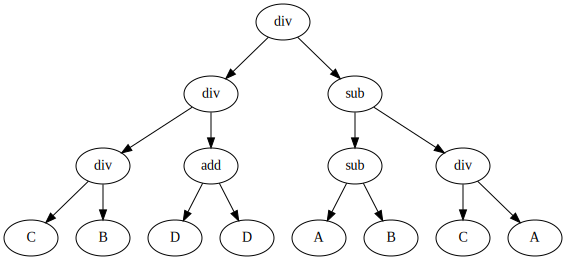

In [11]:
root = fill_random_tree()
print_tree(root)

#### Grow Initialisation


An alternative approach to filling entire trees up to their maximum depth is to grow trees of various sizes. For this we add random nodes while we haven't reached the depth limit. The resulting trees will be less bushy, but the ratio between terminals and non-terminals will bias the average size. 

In [12]:
def grow_random_tree(depth=0):
    tree = Node()
    if depth >= MAX_DEPTH or random.random() > 0.5:
        tree.data = get_random_terminal()
    else:
        tree.data = get_random_function()
        tree.left  = grow_random_tree(depth + 1)
        tree.right = grow_random_tree(depth + 1)
    return tree

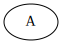

In [13]:
root = grow_random_tree()
print_tree(root)

If the ratio of terminals to functions is high, then we might end up with many trees of size 1. To avoid this, we can define a minimum depth for the trees we want to generate, and only consider terminals once the minimum size has been reached:

In [14]:
MIN_DEPTH = 2

In [15]:
def grow_random_tree(depth=0):
    tree = Node()
    if depth < MIN_DEPTH:
        tree.data = get_random_function()
    elif depth >= MAX_DEPTH:
        tree.data = get_random_terminal()
    else:
        if random.random() > 0.5:
            tree.data = get_random_terminal()
        else:
            tree.data = get_random_function()
                
    if tree.data in FUNCTIONS:
        tree.left  = grow_random_tree(depth + 1)
        tree.right = grow_random_tree(depth + 1)
        
    return tree

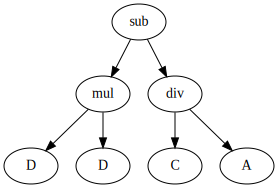

In [16]:
root = grow_random_tree()
print_tree(root)

#### Ramped Half and Half

A common practice when creating the initial population is use a mix of filled and grown trees. For example, half the population may be initialised with the full method, and half with the grow method.

In [17]:
population_size = 40

In [18]:
def get_initial_population():
    population = []
    while len(population) < population_size:
        if random.random() < 0.5:
            population.append(fill_random_tree())
        else:
            population.append(grow_random_tree())
        
    return population

By defining a helper function that calculates the size of a tree, we can look at the distribution of tree sizes:

In [19]:
def size(tree):
    if tree.data in FUNCTIONS:
        l = size(tree.left) if tree.left else 0
        r = size(tree.right) if tree.right else 0
        return 1 + l + r
    else:
        return 1

(array([ 2.,  0.,  0., 12.,  0.,  0.,  4.,  0.,  0., 22.]),
 array([ 9. ,  9.6, 10.2, 10.8, 11.4, 12. , 12.6, 13.2, 13.8, 14.4, 15. ]),
 <BarContainer object of 10 artists>)

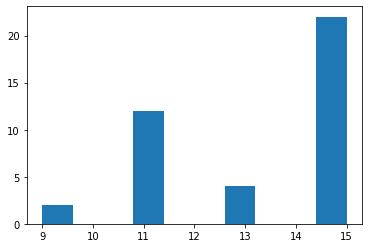

In [20]:
plt.hist([size(x) for x in get_initial_population()])

 Sometimes this is also done using a ramped approach, to generate trees of various sizes:

In [21]:
def get_initial_population():
    population = []
    stages = MAX_DEPTH - MIN_DEPTH + 1
    for stage in range(MIN_DEPTH, MAX_DEPTH + 1):
        for md in range(int(population_size/stages/2)):
            population.append(grow_random_tree(MAX_DEPTH - stage))
        for md in range(int(population_size/stages/2)):
            population.append(fill_random_tree(MAX_DEPTH - stage))
    return population

(array([ 8.,  0., 12.,  0.,  3.,  0.,  4.,  0.,  2., 11.]),
 array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 <BarContainer object of 10 artists>)

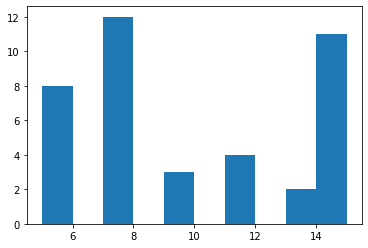

In [22]:
plt.hist([size(x) for x in get_initial_population()])

### Ephemeral Random Constants

Our terminals only include constants (`A` etc), but in practice we might also need actual values, such as numbers. Including all possible numbers in the set of terminals does not scale well. A common approach is therefore to include _ephemeral random constants_: A single terminal represents the choice of a random value; when the terminal is chosen then it is instantiated with an actual random value:

In [23]:
EPHEMERAL_CONSTANT = "R"
TERMINALS = ['A', 'B', 'C', 'D', EPHEMERAL_CONSTANT]
EPHEMERAL_RANGE = 5

In [24]:
def get_random_terminal():
    t = random.choice(TERMINALS)
    if t == EPHEMERAL_CONSTANT:
        t = random.randint(-EPHEMERAL_RANGE, EPHEMERAL_RANGE)
    return t

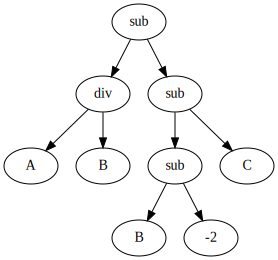

In [25]:
root = grow_random_tree()
print_tree(root)

### Search Operators

Since we have a different representation to what we used in the past (which was mainly list-based), we need to adapt our search operators.

#### Crossover

A basic approach to crossing over two trees is to randomly choose two crossover points in the parent trees, and then to cut and swap subtrees below the crossover points. We first need a function with which we can create copies of trees:

In [26]:
def copy(tree):
    t = Node()
    t.data = tree.data
    if tree.left:  t.left = copy(tree.left)
    if tree.right: t.right = copy(tree.right)
    return t 

We need a couple further helper functions in order to find subtrees at chosen crossover points. First, here's a helper class that allows us to count up or down while (hackily) traversing a tree:

In [27]:
class Counter:
    def __init__(self, num):
        self.num = num
    
    def reduce(self):
        self.num -= 1
        
    def increase(self):
        self.num += 1
    
    def is_target(self):
        return self.num == 0
    
    def greater_zero(self):
        return self.num > 0
    
    def get_value(self):
        return self.num

Using this helper class, we can now traverse the tree and return a copy of the subtree whenever the counter has reached the target:

In [28]:
def get_subtree_at(tree, counter):
    counter.reduce()
    if counter.is_target():
        return copy(tree)
    else:
        ret = None
        if tree.left and counter.greater_zero(): 
            ret = get_subtree_at(tree.left, counter)
        if not ret and tree.right and counter.greater_zero(): 
            ret = get_subtree_at(tree.right, counter)
        return ret

Similarly, we can replace a target node with an entirely different subtree given a counter that tells us when we've reached the target node:

In [29]:
def insert_subtree_at(tree, subtree, counter):
    counter.reduce()
    if counter.is_target():
        tree.data  = subtree.data
        tree.left  = subtree.left
        tree.right = subtree.right
    else:
        if tree.left and counter.greater_zero(): 
            insert_subtree_at(tree.left, subtree, counter)
        if tree.right and counter.greater_zero(): 
            insert_subtree_at(tree.right, subtree, counter)

Using these two functions we can now define a simple crossover function that picks a random subtree from one parent (`parent1`) and inserts it at a random position in the other parent (`parent2`):

In [30]:
def subtree_crossover(parent1, parent2):
    pos1 = random.randint(1, size(parent1))
    pos2 = random.randint(1, size(parent2))
    
    if size(parent1) == 1:
        subtree = copy(parent1)
    else:
        subtree = get_subtree_at(parent1, Counter(pos1))
    offspring = copy(parent2)
    insert_subtree_at(offspring, subtree, Counter(pos2))
    
    return offspring

Let's create some example parents to cross over:

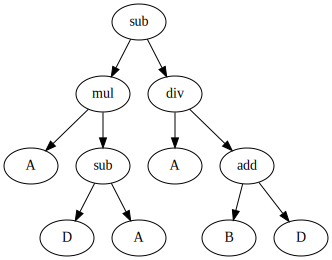

In [31]:
parent1 = grow_random_tree()
print_tree(parent1)

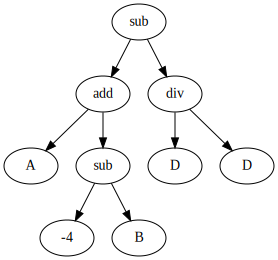

In [32]:
parent2 = grow_random_tree()
print_tree(parent2)

Now we can produce an offspring by calling our `crossover` function with these two parents:

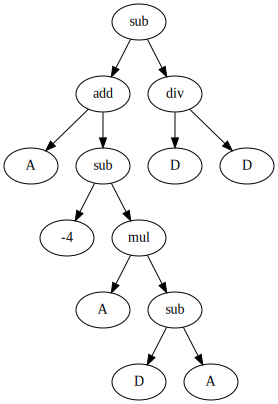

In [33]:
offspring = subtree_crossover(parent1, parent2)
print_tree(offspring)

Often crossover points are not actually sampled with a uniform random distribution though: Given a tree with branching factor 2 or more, the majority of nodes will be leaves, which crossover will mostly cut a single leaf. A common alternative is to apply a 90% probability of choosing a function node, and only a 10% chance of choosing a terminal node.

#### Mutation


Subtree mutation (a.k.a. headless chicken mutation) is a simple mutation where we pick a random subtree, and replace it with a randomly generated subtree:

In [34]:
P_mutate = 0.2

In [35]:
def subtree_mutation(tree):
    mutation_point = random.randint(1, size(tree))
    random_subtree = grow_random_tree(MAX_DEPTH - 2)
    insert_subtree_at(tree, random_subtree, Counter(mutation_point))

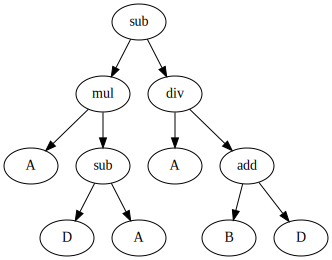

In [36]:
print_tree(parent1)

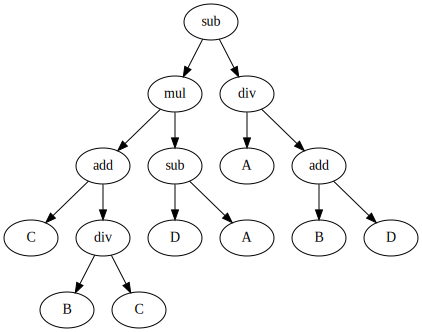

In [37]:
offspring = copy(parent1)
subtree_mutation(offspring)
print_tree(offspring)

An alternative mutation operator is _point mutation_ where, for each node, we replace the node with a certain probability with another node of the same arity.

In [38]:
def point_mutation(tree):
    if random.random() < P_mutate:
        if tree.data in FUNCTIONS: 
            tree.data = random.choice(FUNCTIONS)
        else:
            tree.data = get_random_terminal()
    
    if tree.left:
        point_mutation(tree.left)
    if tree.right:
        point_mutation(tree.right)

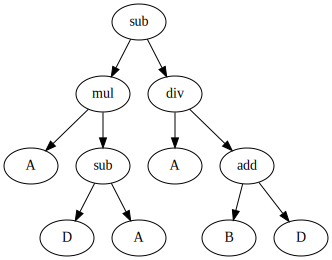

In [39]:
print_tree(parent1)

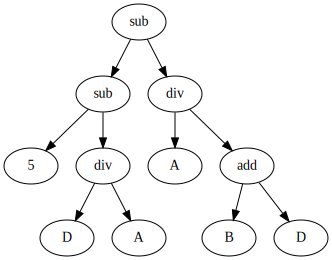

In [40]:
offspring = copy(parent1)
point_mutation(offspring)
print_tree(offspring)

#### Selection


Since selection is independent of the representation, we don't need any adaptations. Since we use a variable size representation, we will include the size as one of the selection criteria.

In [41]:
tournament_size = 3
def tournament_selection(population):
    candidates = random.sample(population, tournament_size)        
    winner = min(candidates, key=lambda x: (get_fitness(x), size(x)))
    return winner

An evolution step of our GA now just needs to integrate these operators:

In [42]:
def evolution_step(population):
    new_population = []
    while len(new_population) < len(population):
        parent1 = copy(selection(population))
        parent2 = copy(selection(population))

        if random.random() < P_xover:
            offspring = crossover(parent1, parent2)
        else:
            offspring = random.choice([parent1, parent2])

        if random.random() < 0.5:
            point_mutation(offspring)
        else:
            subtree_mutation(offspring)

        new_population.append(offspring)

    population.clear()
    population.extend(new_population)

    best_fitness = min([get_fitness(k) for k in population])
    return best_fitness

Similarly, the overall GA is also the same as always:

In [43]:
fitness_values = []
size_values = []

In [44]:
def ga():
    population = get_initial_population()
    best_fitness = sys.maxsize
    for p in population:
        fitness = get_fitness(p)
        if fitness < best_fitness or (fitness == best_fitness and size(p) < size(best_solution)):
            best_fitness = fitness
            best_solution = copy(p)

    iteration = 0
    while iteration < max_iterations and best_fitness > 0.000001:
        fitness_values.append(best_fitness)
        size_values.append(mean([size(x) for x in population]))
        print(f"GA Iteration {iteration}, best fitness: {best_fitness}, average size: {size_values[-1]}")
        iteration += 1
        evolution_step(population)

        for p in population:
            fitness = get_fitness(p)
            if fitness < best_fitness or (fitness == best_fitness and size(p) < size(best_solution)):
                best_fitness = fitness
                best_solution = copy(p)

    print(f"GA solution after {iteration} iterations, best fitness: {best_fitness}")
    return best_solution


### Example Problem: Symbolic Regression

We will use symbolic regression as a first example problem. Given a set of points, we would like to come up with a symbolic expression that represents a function approximating the points. As example equation, we will use $x^2 + x + 1$.

We only have one terminal `x` for this problem, but can also include ephemeral constants:

In [45]:
TERMINALS = ["x", EPHEMERAL_CONSTANT]

As fitness function for how close we are to approximating a set of points we use the sum of absolute errors for all points at different values of `x` in the range [−1.0, +1.0]. Thus, a smaller fitness value is better; a fitness of zero indicates a perfect fit. In order to calculate the error for any given point, we need a helper function that evaluates a tree for a given value of `x`:

In [46]:
def evaluate(tree, assignment):
    if tree.data in FUNCTIONS:
        return tree.data(evaluate(tree.left, assignment), evaluate(tree.right, assignment))
    elif tree.data in assignment:
        return assignment[tree.data]
    else:
        return tree.data

The dictionary `assignment` will map all terminals to actual values during the evaluation. We sample a number of points for measuring the error:

In [47]:
test_data = {}
for value in [x/10 for x in range(-10, 10)]:
    test_data[value] = value*value + value + 1

In [48]:
test_data

{-1.0: 1.0,
 -0.9: 0.91,
 -0.8: 0.8400000000000001,
 -0.7: 0.79,
 -0.6: 0.76,
 -0.5: 0.75,
 -0.4: 0.76,
 -0.3: 0.79,
 -0.2: 0.84,
 -0.1: 0.91,
 0.0: 1.0,
 0.1: 1.11,
 0.2: 1.24,
 0.3: 1.3900000000000001,
 0.4: 1.56,
 0.5: 1.75,
 0.6: 1.96,
 0.7: 2.19,
 0.8: 2.4400000000000004,
 0.9: 2.71}

Now calculating the fitness function reduces to calling the `evaluate` function for each points in our test set, and summing up the differences:

In [49]:
def get_fitness(tree):
    fitness = 0.0
    
    for (x, expected_result) in test_data.items():
        assignment = {"x": x}
        result = evaluate(tree, assignment)
        fitness += (result - expected_result) * (result - expected_result)
    fitness /= len(test_data)
    
    return fitness

With this, we can finally call our genetic algorithm:

GA Iteration 0, best fitness: 0.43833, average size: 9.55
GA Iteration 1, best fitness: 0.20333000000000007, average size: 10.65
GA Iteration 2, best fitness: 0.20333000000000007, average size: 9.6
GA Iteration 3, best fitness: 0.20333000000000007, average size: 11.95
GA Iteration 4, best fitness: 0.20333000000000007, average size: 10.45
GA Iteration 5, best fitness: 0.20333000000000007, average size: 12.15
GA Iteration 6, best fitness: 0.20333000000000007, average size: 16.65
GA Iteration 7, best fitness: 0.20333000000000007, average size: 17
GA Iteration 8, best fitness: 0.20333000000000007, average size: 16.7
GA Iteration 9, best fitness: 0.20333000000000007, average size: 16.8
GA Iteration 10, best fitness: 0.20333000000000007, average size: 15.15
GA Iteration 11, best fitness: 0.20333000000000007, average size: 15.65
GA Iteration 12, best fitness: 0.20333000000000007, average size: 14.75
GA Iteration 13, best fitness: 0.20333000000000007, average size: 14.55
GA Iteration 14, best 

GA Iteration 119, best fitness: 0.09340245657949876, average size: 36.65
GA Iteration 120, best fitness: 0.09340245657949876, average size: 41.75
GA Iteration 121, best fitness: 0.09340245657949876, average size: 52.3
GA Iteration 122, best fitness: 0.09340245657949876, average size: 44.6
GA Iteration 123, best fitness: 0.09340245657949876, average size: 51.9
GA Iteration 124, best fitness: 0.09340245657949876, average size: 47.3
GA Iteration 125, best fitness: 0.09340245657949876, average size: 44.4
GA Iteration 126, best fitness: 0.09340245657949876, average size: 43.9
GA Iteration 127, best fitness: 0.09340245657949876, average size: 58.65
GA Iteration 128, best fitness: 0.09340245657949876, average size: 60.75
GA Iteration 129, best fitness: 0.09340245657949876, average size: 63.65
GA Iteration 130, best fitness: 0.09340245657949876, average size: 76
GA Iteration 131, best fitness: 0.09340245657949876, average size: 69.7
GA Iteration 132, best fitness: 0.09340245657949876, average 

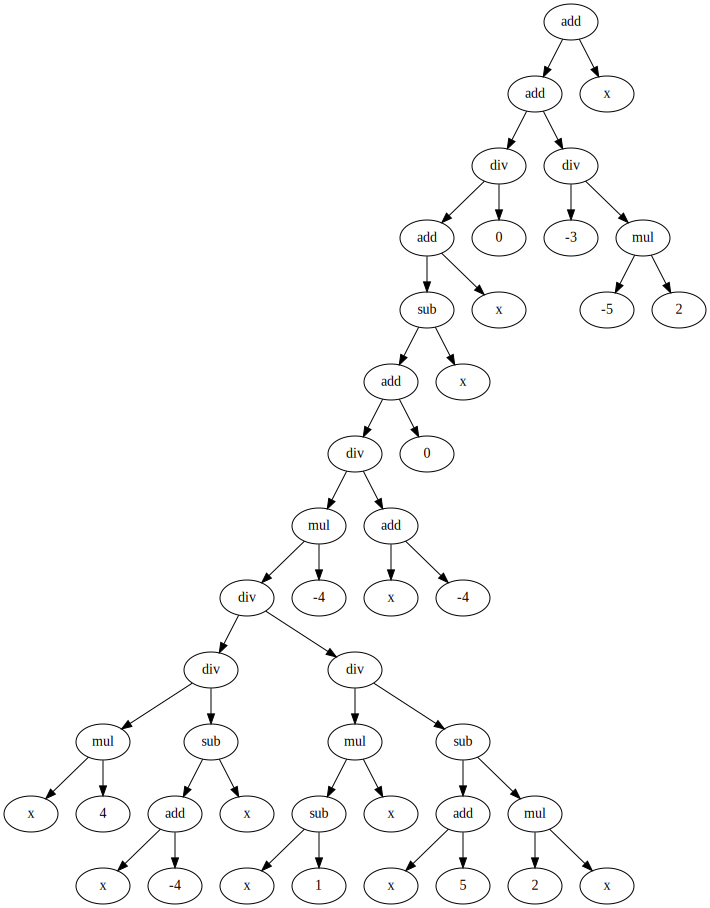

In [50]:
max_iterations = 200
selection = tournament_selection
crossover = subtree_crossover
P_xover = 0.7
fitness_values = []
size_values = []
result = ga()
print_tree(result)

Is the solution actually correct? We can plot the results of this function vs the results of the actual target function to compare:

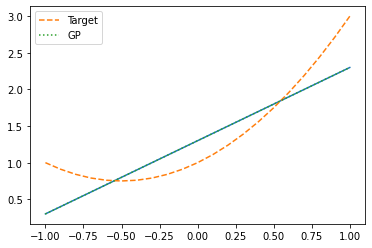

In [51]:
points = [x/10 for x in range(-10, 11)]
real_values = [(x*x + x + 1) for x in points]
gp_values = []
for x in points:
    assignment = {}
    assignment["x"] = x
    gp_values.append(evaluate(result, assignment))
plt.plot(points, gp_values)

plt.plot(points, real_values, linestyle='--', label = "Target")
plt.plot(points, gp_values,  linestyle=':', label = "GP")
plt.legend()

The solution is usually correct; if it is not, try again, and maybe try to adjust the parameters of the GA.

### Handling Bloat

The solution is probably a fairly large tree. Indeed the size is sometimes quite problematic as genetic programming tends to suffer from _bloat_. Let's look at the average population size throughout the evolution:

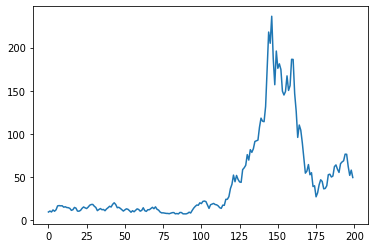

In [52]:
plt.plot(size_values)

We have already adapted our selection operator to counter bloat somewhat, but mutation and crossover also cause an increase in size. We therefore define alternative mutation and crossover operators.

Shrink mutation replaces a random subtree with a terminal node:

In [53]:
def shrink_mutation(individual):
    num_nodes = size(individual)
    if num_nodes < 2:
        return
    
    mutation_point = random.randint(2, num_nodes - 1)
    node = Node()
    node.data = get_random_terminal()
    insert_subtree_at(individual, node, Counter(mutation_point))
    
    return individual

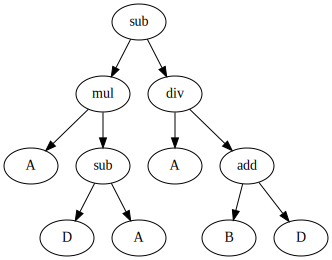

In [54]:
print_tree(parent1)

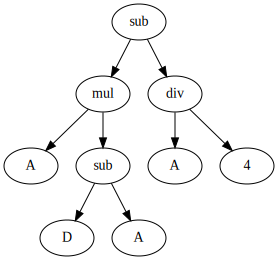

In [74]:
offspring = copy(parent1)
shrink_mutation(offspring)
print_tree(offspring)

Size-fair subtree mutation first picks a random subtree, and then replaces that with a new random subtree that is at most as big as the replaced subtree:

In [56]:
def depth(node):
    d = 0
    if node.left:
        d = max(d, depth(node.left))
    if node.right:
        d = max(d, depth(node.right))
    return d + 1
        

In [57]:
def sizefair_subtree_mutation(tree):
    mutation_point = random.randint(1, size(tree))
    replaced_tree = get_subtree_at(tree, Counter(mutation_point))
    random_subtree = grow_random_tree(MAX_DEPTH - depth(replaced_tree) + 1)
    insert_subtree_at(tree, random_subtree, Counter(mutation_point))

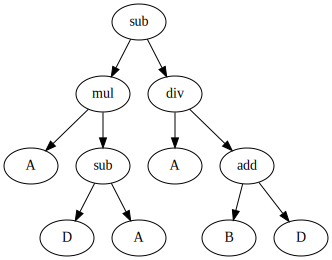

In [58]:
print_tree(parent1)

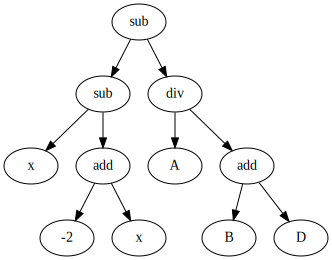

In [79]:
offspring = copy(parent1)
sizefair_subtree_mutation(offspring)
print_tree(offspring)

Permutation mutation shuffles the order of arguments for functions with arity > 1:

In [60]:
def permutation_mutation(tree):
    if random.random() < P_mutate:
        if tree.data in FUNCTIONS: 
            tree.left, tree.right = tree.right, tree.left
    
    if tree.left:
        permutation_mutation(tree.left)
    if tree.right:
        permutation_mutation(tree.right)

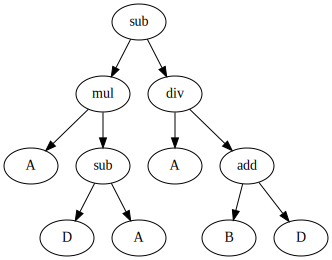

In [61]:
print_tree(parent1)

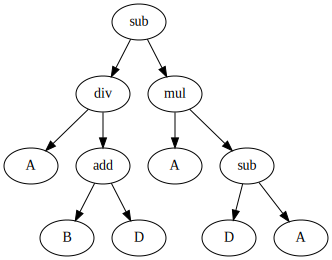

In [82]:
offspring = copy(parent1)
permutation_mutation(offspring)
print_tree(offspring)

There is also a size-fair variant of the crossover operator we defined earlier: We first pick a random crossover point in the first parent. Then, we pick a subtree in the other parent that is not larger than the subtree in the first parent, and perform the crossover with this. We thus define a helper function that gives us all valid positions with subtrees of a maximum size:

In [63]:
def get_smaller_subtree_positions(tree, max_size, positions, counter):
    if size(tree) <= max_size:
        positions.append(counter.get_value())
    counter.increase()
    
    if tree.left:
        get_smaller_subtree_positions(tree.left, max_size, positions, counter)
    if tree.right:
        get_smaller_subtree_positions(tree.right, max_size, positions, counter)

We apply this helper function by simply randomly picking one of the valid positions during crossover:

In [64]:
def sizefair_crossover(parent1, parent2):
    
    # First pick a crossover point in parent1
    pos1 = 1
    if size(parent1) > 1:
        pos1 = random.randint(1, size(parent1) - 1)

    # Then select a subtree that isn't larger than what is being replaced from parent2
    subtree = get_subtree_at(parent1, Counter(pos1))
    subtree_size = size(subtree)    
    positions = []
    get_smaller_subtree_positions(parent2, subtree_size, positions, Counter(1))
    pos2 = random.choice(positions)
    subtree = get_subtree_at(parent2, Counter(pos2))
    
    # Then insert that into parent1
    offspring = copy(parent1)
    insert_subtree_at(offspring, subtree, Counter(pos1))
    
    assert size(offspring) <= size(parent1)
    
    return offspring

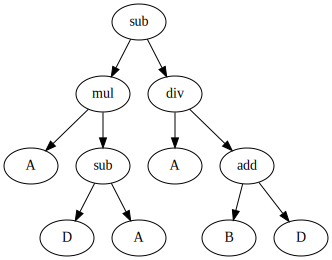

In [65]:
print_tree(parent1)

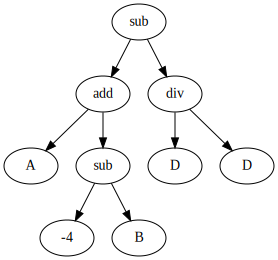

In [66]:
print_tree(parent2)

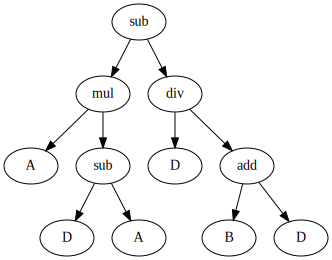

In [67]:
offspring = sizefair_crossover(parent1, parent2)
print_tree(offspring)

Now we just need to do some minor adaptations to make sure that these new operators are actually applied during the evolution:

In [68]:
mutation_operators = [subtree_mutation, permutation_mutation, shrink_mutation, point_mutation, sizefair_subtree_mutation]
crossover = sizefair_crossover

Besides the adapted operators, another common approach is to apply an upper bound on the size, and reject offspring that exceeds that size. This can have negative implications if it is the only means to control bloat, as larger individuals will then become less likely to produce surviving offspring. However, we can use it in conjunction with out optimised operators:

In [69]:
REJECT_SIZE = 50

In [70]:
def evolution_step(population):
    new_population = []
    while len(new_population) < len(population):
        parent1 = copy(selection(population))
        parent2 = copy(selection(population))

        if random.random() < P_xover:
            offspring = crossover(parent1, parent2)
        else:
            offspring = random.choice([parent1, parent2])

        if random.random() < 0.2:
            mutation_operator = random.choice(mutation_operators)
            mutation_operator(offspring)

        if size(offspring) < REJECT_SIZE:
            new_population.append(offspring)

    population.clear()
    population.extend(new_population)

    best_fitness = min([get_fitness(k) for k in population])
    return best_fitness

Thus, finally, let's run the search again for the same target function.

GA Iteration 0, best fitness: 0.20333000000000007, average size: 9.48
GA Iteration 1, best fitness: 0.20333000000000007, average size: 8.5
GA Iteration 2, best fitness: 0.05937476232444309, average size: 8.42
GA Iteration 3, best fitness: 0.05937476232444309, average size: 7.92
GA Iteration 4, best fitness: 0.05937476232444309, average size: 7.52
GA Iteration 5, best fitness: 0.05937476232444309, average size: 7.06
GA Iteration 6, best fitness: 0.05937476232444309, average size: 6.08
GA Iteration 7, best fitness: 0.05937476232444309, average size: 6
GA Iteration 8, best fitness: 0.05937476232444309, average size: 5
GA Iteration 9, best fitness: 0.05937476232444309, average size: 4.64
GA Iteration 10, best fitness: 0.05937476232444309, average size: 4.06
GA Iteration 11, best fitness: 0.05937476232444309, average size: 3.9
GA Iteration 12, best fitness: 0.05937476232444309, average size: 3.94
GA Iteration 13, best fitness: 0.05937476232444309, average size: 3.96
GA Iteration 14, best fi

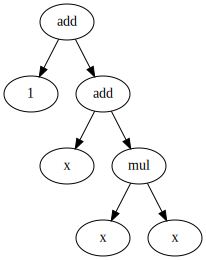

In [71]:
max_iterations = 200
population_size = 100
selection = tournament_selection
crossover = sizefair_crossover
P_xover = 0.7
fitness_values = []
size_values = []
result = ga()
print_tree(result)

To validate whether we are still affected by bloat we can plot the evolution of size again:

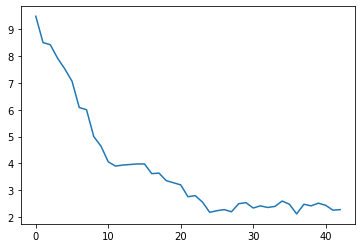

In [72]:
plt.plot(size_values)

We can also compare the resulting function with the desired target function:

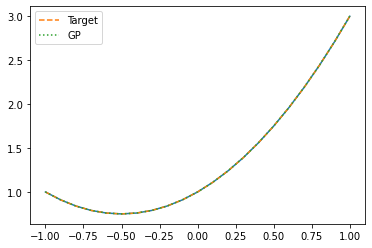

In [73]:
points = [x/10 for x in range(-10, 11)]
real_values = [(x*x + x + 1) for x in points]
gp_values = []
for x in points:
    assignment = {}
    assignment["x"] = x
    gp_values.append(evaluate(result, assignment))
plt.plot(points, gp_values)

plt.plot(points, real_values,  linestyle='--', label = "Target")
plt.plot(points, gp_values,  linestyle=':', label = "GP")
plt.legend()